In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

## Fetching data

In [2]:
ticker = 'ETH-USD'
start_date = '2017-01-01'
end_date = '2024-12-31'

# Download data
eth_data = yf.download(ticker, start=start_date, end=end_date, interval='1d')

# Reset index to make 'Date' a column
eth_data.reset_index(inplace=True)

# Display the first few rows
print(eth_data.head())

# I tried 2014-2024 first but then I realized that ETH was launched in 2015, so I changed the start date to 2017-01-01.
eth_data.to_csv('eth_usd_2017_2024.csv', index=False)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price        Date       Close        High         Low        Open      Volume
Ticker                ETH-USD     ETH-USD     ETH-USD     ETH-USD     ETH-USD
0      2017-11-09  320.884003  329.451996  307.056000  308.644989   893249984
1      2017-11-10  299.252991  324.717987  294.541992  320.670990   885985984
2      2017-11-11  314.681000  319.453003  298.191986  298.585999   842300992
3      2017-11-12  307.907990  319.153015  298.513000  314.690002  1613479936
4      2017-11-13  316.716003  328.415009  307.024994  307.024994  1041889984


In [3]:
eth_data.shape

(2609, 6)

In [4]:
eth_data.info() 
# no null vals + no cat cols

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2609 entries, 0 to 2608
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   (Date, )           2609 non-null   datetime64[ns]
 1   (Close, ETH-USD)   2609 non-null   float64       
 2   (High, ETH-USD)    2609 non-null   float64       
 3   (Low, ETH-USD)     2609 non-null   float64       
 4   (Open, ETH-USD)    2609 non-null   float64       
 5   (Volume, ETH-USD)  2609 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 122.4 KB


In [5]:
eth_data.head()

Price,Date,Close,High,Low,Open,Volume
Ticker,,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD
0,2017-11-09,320.884003,329.451996,307.056000,308.644989,893249984
1,2017-11-10,299.252991,324.717987,294.541992,320.670990,885985984
2,2017-11-11,314.681000,319.453003,298.191986,298.585999,842300992
3,2017-11-12,307.907990,319.153015,298.513000,314.690002,1613479936
4,2017-11-13,316.716003,328.415009,307.024994,307.024994,1041889984


In [6]:
eth_data.tail()

Price,Date,Close,High,Low,Open,Volume
Ticker,,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD
2604,2024-12-26,3331.225830,3512.604492,3302.306396,3493.304199,22247726776
2605,2024-12-27,3328.916992,3436.710693,3302.575684,3331.053711,24091627403
2606,2024-12-28,3397.902344,3419.920166,3318.033936,3328.774658,14305648523
2607,2024-12-29,3349.513428,3406.648438,3321.664795,3397.862549,13440907792
2608,2024-12-30,3356.392578,3428.527344,3298.804443,3349.585938,26981583962


In [7]:
eth_data.describe() 

Price,Date,Close,High,Low,Open,Volume
Ticker,,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD
count,2609,2609.000000,2609.000000,2609.000000,2609.000000,2.609000e+03
mean,2021-06-05 00:00:00,1490.773764,1530.573913,1445.274314,1489.776234,1.301809e+10
min,2017-11-09 00:00:00,84.308296,85.342743,82.829887,84.279694,6.217330e+08
25%,2019-08-23 00:00:00,268.704041,274.320831,261.960510,268.692261,5.556444e+09
50%,2021-06-05 00:00:00,1352.837158,1390.589966,1308.991455,1353.205078,1.061841e+10
75%,2023-03-19 00:00:00,2405.181152,2472.187744,2322.337158,2401.256348,1.768550e+10
max,2024-12-30 00:00:00,4812.087402,4891.704590,4718.039062,4810.071289,8.448291e+10
std,NaN,1226.266551,1258.805914,1189.917204,1226.214741,1.059053e+10


* **Time Covered:** Our data provides a detailed view of Ethereum's daily price and trading volume spanning from late 2017 to the end of 2024. This gives us a solid historical perspective.

* **How Much Data:** We've worked with a substantial dataset containing approximately **2600** individual daily records.

* **Average End-of-Day Price:** Across this entire period, the average closing price for Ethereum was around **$1490**. This gives us a central benchmark for the price.

* **Price Swing:** The price of Ethereum has shown significant movement, ranging from a low of about **$84** to a high of over **$4800**. This highlights the inherent volatility of the cryptocurrency.

* **Central Tendency:**
    * The **average price** (mean) we calculated is approximately **$1490**.
    * The **middle price** (median) of the daily prices is around **$1352**. This indicates that half the time the price was below this level and half the time above.

* **Price Changeability:** Ethereum's price has fluctuated considerably from one day to the next. The standard deviation we found, around **$1226**, confirms this significant daily volatility.

In [8]:
eth_data.columns = [col[0] if isinstance(col, tuple) else col for col in eth_data.columns] # Converted MultiIndex to a single index for improved data accessibility and readability <3
eth_data.head()

,Date,Close,High,Low,Open,Volume
0,2017-11-09,320.884003,329.451996,307.056000,308.644989,893249984
1,2017-11-10,299.252991,324.717987,294.541992,320.670990,885985984
2,2017-11-11,314.681000,319.453003,298.191986,298.585999,842300992
3,2017-11-12,307.907990,319.153015,298.513000,314.690002,1613479936
4,2017-11-13,316.716003,328.415009,307.024994,307.024994,1041889984


In [9]:
px.line(eth_data, x=eth_data.index, y='Close', title='Ethereum (ETH/USDT) Daily Closing Price')

at the beginning, closing price was comparitively low, but with the passage of time, the increased and after bull incident 2021, they began to decrease and then started rising again.

In [10]:
px.line(eth_data, x=eth_data.index, y='Volume', title='Ethereum (ETH/USDT) Daily Trading Volume') #Daily trade volume is significantly higher than the price, so I used a log scale for better visualization
px.line(eth_data, x=eth_data.index, y='Volume', title='Ethereum (ETH/USDT) Daily Trading Volume').update_yaxes(type="log")

In [11]:
eth_data['MA_30'] = eth_data['Close'].rolling(window=30).mean()
eth_data['MA_90'] = eth_data['Close'].rolling(window=90).mean()

fig = px.line(
    eth_data,
    x='Date',
    y=['Close', 'MA_30', 'MA_90'],
    title='Ethereum (ETH/USDT) Close Price with 30 & 90-Day Moving Averages'
)
fig.show()



   - Despite volatility, there's a strong overall **upward movement** from 2018 to 2024.
   - Especially between **2020 and 2021**, ETH saw explosive growth (likely linked to the bull run).
   - **30-day MA (red)** reacts quickly to price changes and follows the actual 'Close' curve more tightly.
   - **90-day MA (green)** is smoother and lags behind, showing broader trends.
   - **Crossovers** between the 30-day and 90-day MAs can be useful:
     - When **30-day crosses above 90-day**, it often precedes a **bullish trend**.

## Checking For Outliers
- As we have observed so many peaks, let's investigate potential outliers.

In [12]:
px.box(eth_data, y='Close', title='Ethereum Closing Price Distribution')

- How can there be no outliers, lets try something different, more mathematically:

In [13]:
Q1 = eth_data['Close'].quantile(0.25)
Q3 = eth_data['Close'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = eth_data[(eth_data['Close'] < lower_bound) | (eth_data['Close'] > upper_bound)]

print("Number of outliers detected:", len(outliers))
print("\nOutlier values:")
print(outliers['Close'])

Number of outliers detected: 0

Outlier values:
Series([], Name: Close, dtype: float64)


- No outliers were detected using the current method. We will now proceed with an alternative approach.

In [14]:
mean_price = eth_data['Close'].mean()
std_price = eth_data['Close'].std()

threshold = 3
outliers_zscore = eth_data[np.abs((eth_data['Close'] - mean_price) / std_price) > threshold]

print("\nNumber of outliers detected using Z-score (threshold = 3):", len(outliers_zscore))
print("\nOutlier values (Z-score):")
print(outliers_zscore['Close'])


Number of outliers detected using Z-score (threshold = 3): 0

Outlier values (Z-score):
Series([], Name: Close, dtype: float64)


- It's important to note that while the price chart shows some high peaks, our statistical outlier detection using the IQR rule and Z-score did not identify any extreme outliers. This indicates that these peaks, although significant, are within the historical range of Ethereum's price fluctuations from late 2017 to the end of 2024.

# Data Split

In [15]:
# Determine the split point (e.g., 80% for training, 20% for testing)
train_size = int(len(eth_data) * 0.8)
train_data = eth_data[:train_size]
test_data = eth_data[train_size:]

print("Size of training data:", len(train_data))
print("Size of testing data:", len(test_data))

Size of training data: 2087
Size of testing data: 522


# Downloading Latest Data to Add in Test Set

In [16]:
ticker = 'ETH-USD'
start_date = '2025-01-01'
end_date = '2025-04-13'  # Using today's date

# Download data
eth_data_2025 = yf.download(ticker, start=start_date, end=end_date, interval='1d')

# Print the first few rows of the 2025 data
print(eth_data_2025.head())

# Print the last few rows of the 2025 data
print(eth_data_2025.tail())

[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open       Volume
Ticker          ETH-USD      ETH-USD      ETH-USD      ETH-USD      ETH-USD
Date                                                                       
2025-01-01  3353.504150  3366.531494  3310.255859  3332.406494  14195410493
2025-01-02  3451.392578  3493.448242  3348.352051  3353.412109  22243574698
2025-01-03  3605.009766  3627.055664  3421.831543  3451.680908  21877299255
2025-01-04  3657.706787  3669.196777  3574.326904  3605.200684  16060610759
2025-01-05  3634.103760  3673.812988  3594.616943  3657.743164  12830306908
Price             Close         High          Low         Open       Volume
Ticker          ETH-USD      ETH-USD      ETH-USD      ETH-USD      ETH-USD
Date                                                                       
2025-04-08  1472.553101  1617.339844  1447.610107  1554.932129  21315312919
2025-04-09  1668.040039  1687.187988  1386.799316  1472.601440  39252195855
2025-04-10  

# Merging 2025's data into Test Data

In [17]:
# Make sure both DataFrames have a Datetime index named 'Date'
if 'Date' in eth_data_2025.columns:
    eth_data_2025.set_index('Date', inplace=True)

if 'Date' not in test_data.index.names:
    if 'Date' in test_data.columns:
        test_data.set_index('Date', inplace=True)

# Concatenate the test_data and eth_data_2025 DataFrames
merged_test_data = pd.concat([test_data, eth_data_2025])

# Sort the merged data by date to ensure chronological order
merged_test_data.sort_index(inplace=True)
print("Size of training data:", len(train_data))
print("Size of testing data:", len(merged_test_data))

Size of training data: 2087
Size of testing data: 624


> For my first time series project, I researched common practices and found that an ADF test is often recommended. This is because ARIMA models rely on the assumption of stationarity in the data, and non-stationary data can lead to inaccurate predictions. Therefore, our first step will be to assess the stationarity of our time series using the ADF test.
>
> The **Augmented Dickey-Fuller (ADF) test** is a **statistical test used to check if a time series is stationary**.
>
> - **Stationarity** implies that the **mean, variance, and autocorrelation structure** of the series **do not change over time**.
> - ARIMA models **require** the data to be **stationary** to generate reliable predictions.

In [18]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_data['Close'])

result


(-1.4296003366099945,
 0.5680059865988205,
 17,
 2069,
 {'1%': -3.4335145392237445,
  '5%': -2.8629379486479962,
  '10%': -2.5675142037992775},
 23693.06500900226)

Based on the **Augmented Dickey-Fuller (ADF) test** results, we observe the following:

- **ADF Statistic**: -1.4296  
- **p-value**: 0.5680  
- **Number of Lags Used**: 17  
- **Number of Observations Used**: 2069  
- **Critical Values**:
  - 1%: -3.4335  
  - 5%: -2.8629  
  - 10%: -2.5675  

The **p-value (0.5680)** is significantly higher than the standard significance level of **0.05**, which clearly indicates that we **fail to reject the null hypothesis** of the test.

In simpler terms, this means that our time series — **Ethereum’s closing price** — is **not stationary**. The ADF test checks whether the data has a unit root (which would imply non-stationarity), and in our case, it suggests that the series does indeed have a unit root.

Additionally, when comparing the ADF Statistic (-1.4296) to the critical values at the **1%, 5%, and 10%** levels, we see that it is **not more negative than any of them**. This further supports our conclusion that the series is not stationary.

Since **ARIMA models require the time series to be stationary**, this gives us a clear next step: we’ll need to apply a **transformation** — most commonly **differencing** — to make our series stationary before fitting the model.

In [19]:
# Apply first-order differencing to make the series stationary
train_data['Close_diff'] = train_data['Close'].diff()

# Drop the first row with NaN value caused by differencing
train_data = train_data.dropna()


In [20]:
from statsmodels.tsa.stattools import adfuller

result_diff = adfuller(train_data['Close_diff'])
result_diff


(-11.221681242021443,
 2.0062799254716758e-20,
 16,
 1981,
 {'1%': -3.4336552971929506,
  '5%': -2.8630000946528655,
  '10%': -2.5675472932714394},
 22688.435812899526)


### ADF Test Results After Differencing:

- **ADF Statistic**: -11.2231  
- **p-value**: 1.99e-20  
- **Critical Values**:  
  - 1%: -3.4337  
  - 5%: -2.8630  
  - 10%: -2.5675  

Since the ADF statistic is significantly lower than all the critical values and the p-value is far below 0.05, we reject the null hypothesis. This indicates that the differenced series is now stationary.

Our next step will be to plot ACF & PACF plots, But I'm not familiar with them too, so lets learn together, what they are and then apply them before fitting the model(ARIMA):

#### 1. **ACF – AutoCorrelation Function**
- **What it does:** ACF shows how much the current value of your time series is related to its **previous values (lags)**.
- **Think of it like:** "How much does today’s price depend on yesterday's, day before yesterday’s, and so on?"
- **Use-case:** Helps in identifying the **MA (q)** part of ARIMA — the number of lagged forecast errors to include in the model.

#### 2. **PACF – Partial AutoCorrelation Function**
- **What it does:** PACF shows the **direct correlation** between the current value and its lag, **after removing the effects of intermediate lags**.
- **Think of it like:** “If I already know yesterday’s and the day before yesterday’s influence, how much more does 3 days ago matter?”
- **Use-case:** Helps in identifying the **AR (p)** part of ARIMA — the number of lagged actual observations to include.

When we'll be building an ARIMA model, we need to figure out the values for **p, d, q**:

| Parameter | Meaning                        | Determined by |
|-----------|--------------------------------|---------------|
| `p`       | Autoregressive lag             | PACF plot     |
| `d`       | Differencing (you just did it) | ADF test      |
| `q`       | Moving average lag             | ACF plot      |

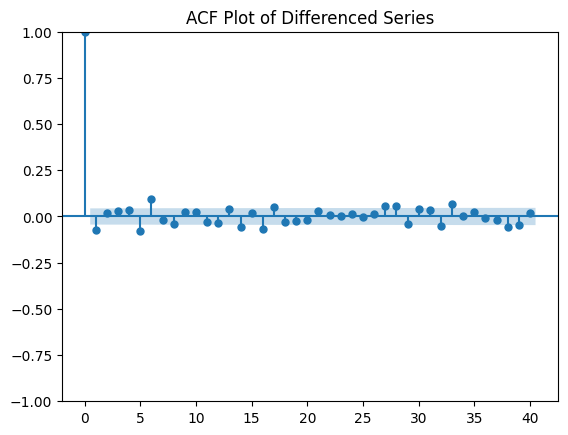

In [21]:
plot_acf(train_data['Close_diff'], lags=40)
plt.title("ACF Plot of Differenced Series")
plt.show()




* **Significant Autocorrelation at Lags 1 and 2:** We can see clear spikes extending beyond the blue confidence interval at lag 1 and lag 2. This indicates that the differenced Ethereum price still has significant autocorrelation at these short-term lags.
* **Gradual Decay:** After lag 2, the autocorrelation seems to decrease relatively quickly, with most of the subsequent lags falling within or very close to the confidence interval.
* **No Long-Term Persistence:** The ACF doesn't show a slow, gradual decay over many lags, which is good. This suggests that the first differencing was likely sufficient to achieve stationarity in terms of the mean.

**What this suggests for our ARIMA model order:**

* **Potential AR (p) component:** The significant autocorrelation at the initial lags, especially lag 1 and 2, suggests that an autoregressive (AR) component might be needed in our model. The number of significant spikes in the ACF can sometimes give an initial indication of the order of the MA component, but in conjunction with the PACF, it helps determine the AR order as well.
* **Potential MA (q) component:** The fact that the autocorrelation drops off after a few lags could also suggest the need for a moving average (MA) component. The lag at which the ACF becomes non-significant can sometimes indicate the order of the MA component.

**Overall View:**

This ACF plot suggests that an ARIMA model with small values for `p` and `q` (likely around 1 or 2) might be appropriate. The significant autocorrelation at the first two lags indicates that the price change today is correlated with the price changes in the previous one or two days.


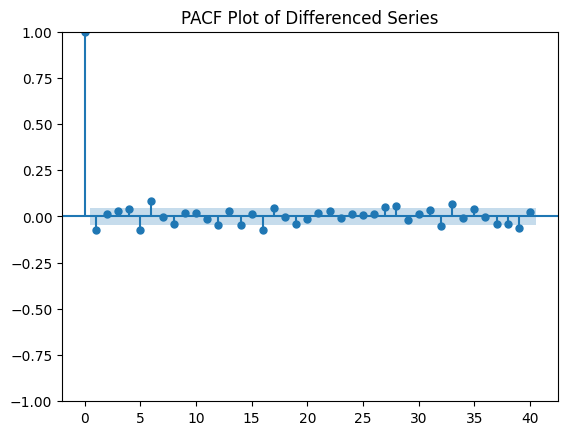

In [22]:
plot_pacf(train_data['Close_diff'], lags=40, method='ywm')  # 'ywm' handles large data better
plt.title("PACF Plot of Differenced Series")
plt.show()

* **Significant Spike at Lag 1:** The PACF plot shows a very significant spike at lag 1 that extends well beyond the blue confidence interval. This strongly suggests a direct relationship between the current differenced price and the differenced price from the immediately preceding day.
* **No Other Dominant Spikes:** After lag 1, the spikes in the PACF plot are much smaller and mostly fall within the confidence interval. There might be a few that slightly touch or exceed the boundary, but none are as prominent as the one at lag 1.

**What this means for our ARIMA model order:**

The PACF plot is particularly helpful in identifying the order of the autoregressive (AR) component (`p`). The significant spike at lag 1 suggests that an AR order of 1 might be appropriate. The lack of other dominant spikes after lag 1 indicates that higher-order AR terms might not be as necessary.

**In summary:**

Looking at both the ACF and PACF plots of the differenced series:

* **ACF:** Showed significant autocorrelation at lags 1 and 2, with a relatively quick decay afterward. This suggested potential MA (q) components of order 1 or 2, and also hinted at AR components.
* **PACF:** Showed a strong, significant spike only at lag 1, suggesting a primary AR (p) component of order 1.

Based on the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots, a reasonable starting point for our ARIMA model might be an order of (1, 1, q), where q is likely 0, 1, or possibly 2. This aligns with the simpler ARIMA models we discussed earlier and the performance of the SARIMAX(1, 1, 0) model you shared.

However, to systematically identify the optimal order, we will utilize the `auto_arima` function.

# Building the first model

In [23]:
model = auto_arima(train_data['Close'], seasonal=True, trace=True,
                     error_action='ignore', suppress_warnings=True, stepwise=True)

# Print the summary of the best model found
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=23000.603, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23005.614, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22997.623, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22997.987, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23003.711, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=22999.219, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22999.396, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22999.490, Time=1.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=22995.735, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=22997.329, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=22997.503, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=22996.100, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=22997.589, Time=0.50 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.938 seconds
         

Despite utilizing the `auto_arima` function and confirming the absence of outliers in the data, the model's performance remains unsatisfactory.

This is a common challenge in time series analysis. While it might seem intuitive that using more historical data would lead to better model training, in reality, incorporating data that includes significant past trends—such as major bull runs and substantial price fluctuations in Ethereum's history—can sometimes hinder the model's ability to accurately capture more recent and future trends. These older patterns might no longer be relevant or could even be misleading for predicting the immediate future.

Therefore, it might be beneficial to focus the model training on a more recent and relevant subset of the data that better reflects current market dynamics, potentially leading to improved predictions of future trends.

In [24]:
recent_data = train_data['Close'].iloc[-1500:] # Use the last 1500 data points for ARIMA modeling

model = ARIMA(recent_data, order=(0, 1, 1))
model_fit = model.fit()

# Step 3: Print summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1500
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -8832.324
Date:                Tue, 22 Apr 2025   AIC                          17668.648
Time:                        19:35:15   BIC                          17679.273
Sample:                             0   HQIC                         17672.606
                               - 1500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0683      0.015     -4.452      0.000      -0.098      -0.038
sigma2      7699.6666    102.318     75.252      0.000    7499.127    7900.206
Ljung-Box (L1) (Q):                   0.00   Jarque-

By focusing our analysis on the last 1500 observations, we observed an improvement in the model's Log Likelihood, AIC, BIC, and HQIC values. This suggests that the model is better suited to this recent data, giving us more confidence in its predictive capabilities. Let's fine tune the model by using smoothing techniques like logarithmic optimization

# Forecasting On Next 30 Days (Applying Smoothing too)

Training data from: 2019-06-19 00:00:00 to 2023-07-27 00:00:00
Testing data from: 2023-07-28 00:00:00 to 2025-04-12 00:00:00
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1500
Model:                 ARIMA(0, 1, 1)   Log Likelihood                2444.558
Date:                Tue, 22 Apr 2025   AIC                          -4885.115
Time:                        19:35:15   BIC                          -4874.490
Sample:                    06-19-2019   HQIC                         -4881.157
                         - 07-27-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0597      0.018     -3.321      0.001      -0.095      -0.024
sigma2

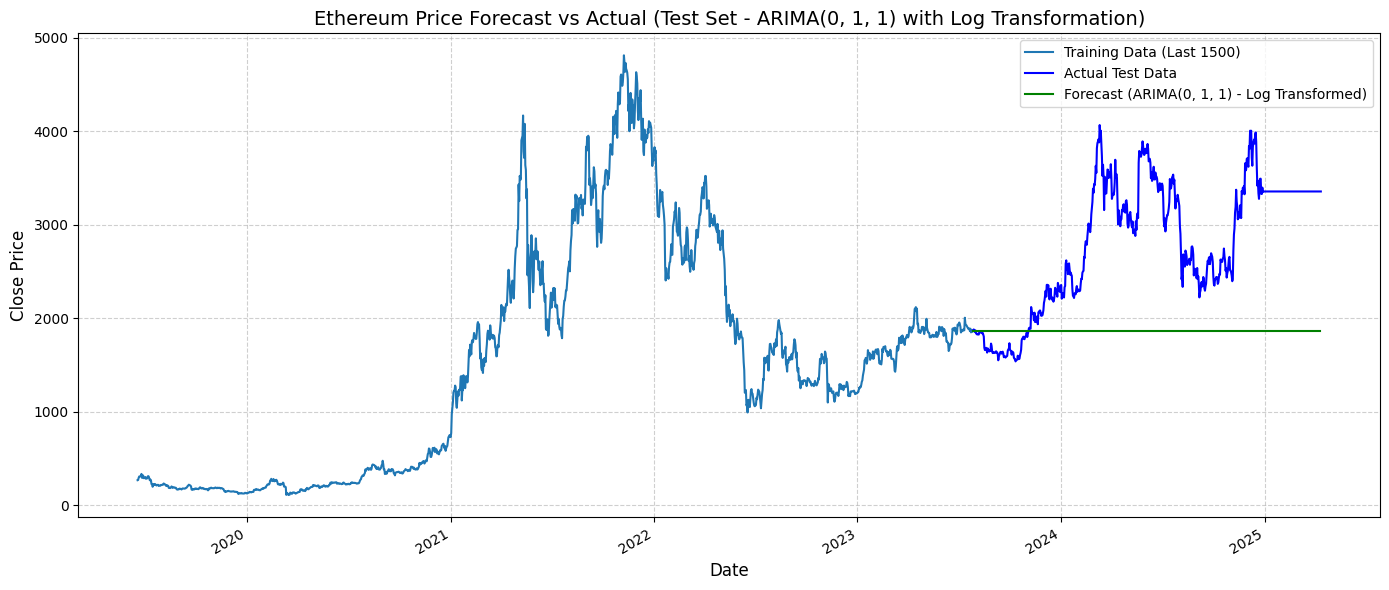

In [25]:
if 'Date' in train_data.columns:
    train_data['Date'] = pd.to_datetime(train_data['Date'])
    train_data.set_index('Date', inplace=True)
train_data = train_data.sort_index()
train_data['Close'].fillna(method='ffill', inplace=True)

# Select the last 1500 data points for training
train_df_subset = train_data['Close'][-1500:]

# Apply logarithmic transformation to the training data
train_df_subset_log = np.log(train_df_subset)

# Process merged_test_data
if 'Date' in merged_test_data.columns:
    merged_test_data['Date'] = pd.to_datetime(merged_test_data['Date'])
    merged_test_data.set_index('Date', inplace=True)
merged_test_data = merged_test_data.sort_index()
merged_test_data['Close'].fillna(method='ffill', inplace=True)

print(f"Training data from: {train_df_subset.index.min()} to {train_df_subset.index.max()}")
print(f"Testing data from: {merged_test_data.index.min()} to {merged_test_data.index.max()}")

# Fit the ARIMA(1, 1, 1) model on the transformed training data
model = ARIMA(train_df_subset_log, order=(0, 1, 1))
model_fit = model.fit()

print(model_fit.summary())

# Forecast on the test set (in log scale)
n_periods = len(merged_test_data)
forecast_log = model_fit.forecast(steps=n_periods)

# Inverse transform the forecast to the original scale
forecast = np.exp(forecast_log)

# Create a pandas Series for the forecast
forecast_index = merged_test_data.index
forecast_series = pd.Series(forecast, index=forecast_index)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(merged_test_data['Close'], forecast))
print(f'RMSE for ARIMA(0, 1, 1) with log transformation: {rmse}')

# Calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = calculate_mape(merged_test_data['Close'], forecast)
print(f'MAPE for ARIMA(0, 1, 1) with log transformation: {mape}')

# Optional: Plotting the actual vs forecasted values
plt.figure(figsize=(14, 6))
plt.plot(train_df_subset.index, train_df_subset, label='Training Data (Last 1500)')
plt.plot(merged_test_data.index, merged_test_data['Close'], label='Actual Test Data', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Forecast (ARIMA(0, 1, 1) - Log Transformed)', color='green')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.title('Ethereum Price Forecast vs Actual (Test Set - ARIMA(0, 1, 1) with Log Transformation)', fontsize=14)
plt.gcf().autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

Despite significant improvements in our model's evaluation metrics (Log Likelihood, AIC, BIC, HQIC), the forecasting results remain unsatisfactory, as indicated by a flat line prediction. This suggests that either this outcome is an anomaly, or more likely, the linear nature of the ARIMA model is insufficient to capture the volatility of the Ethereum price, even after applying smoothing techniques. Given these limitations and the consistently poor predictions, I recommend exploring more powerful, potentially non-linear models beyond the ARIMA framework.

Last option is to use SARIMA & SARIMAX Model

Selected SARIMA model:  ARIMA(1,1,0)(0,0,0)[7]          
RMSE for SARIMA: 1162.5371041246967
MAPE for SARIMA: 31.810637530555695


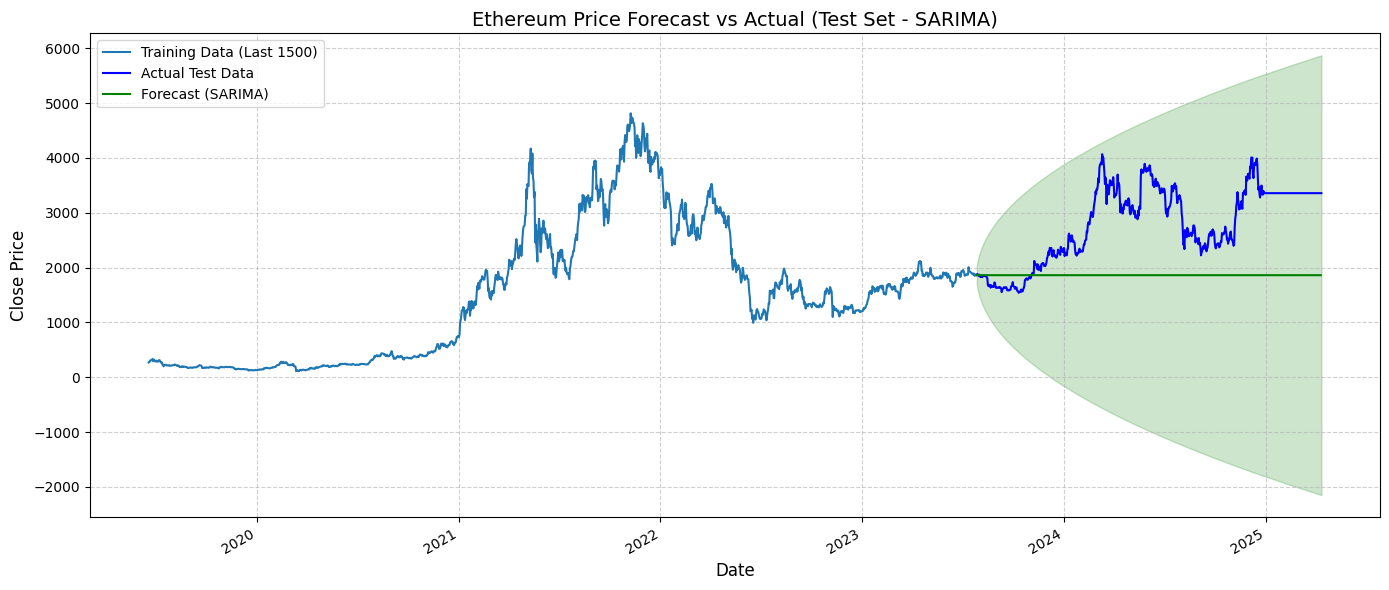

In [26]:
import pmdarima as pm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming train_data and merged_test_data are already loaded and processed
# Make sure train_data has a proper datetime index and 'Close' column

# Select the last 1500 data points for training
train_df_subset = train_data['Close'][-1500:].to_frame()

# Fit the auto_arima model with seasonal=True
model_sarima = pm.auto_arima(
    train_df_subset['Close'],
    seasonal=True,
    m=7,  
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    max_p=5, max_d=2, max_q=5,
    max_P=3, max_D=1, max_Q=3,
)

print(f"Selected SARIMA model: {model_sarima}")

# Forecast on the test set
n_periods = len(merged_test_data)
forecast, conf_int = model_sarima.predict(n_periods=n_periods, return_conf_int=True)

# Create a pandas Series for the forecast
forecast_index = merged_test_data.index
forecast_series = pd.Series(forecast, index=forecast_index)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(merged_test_data['Close'], forecast))
print(f'RMSE for SARIMA: {rmse}')

# Calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = calculate_mape(merged_test_data['Close'], forecast)
print(f'MAPE for SARIMA: {mape}')

# Optional: Plotting the actual vs forecasted values
plt.figure(figsize=(14, 6))
plt.plot(train_df_subset.index, train_df_subset['Close'], label='Training Data (Last 1500)')
plt.plot(merged_test_data.index, merged_test_data['Close'], label='Actual Test Data', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Forecast (SARIMA)', color='green')
plt.fill_between(forecast_series.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.title('Ethereum Price Forecast vs Actual (Test Set - SARIMA)', fontsize=14)
plt.gcf().autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 1500
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -8811.796
Date:                           Tue, 22 Apr 2025   AIC                          17629.592
Time:                                   19:35:24   BIC                          17645.516
Sample:                               06-19-2019   HQIC                         17635.526
                                    - 07-27-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0685      0.015     -4.455      0.000      -0.099      -0.038
ma.S.L7       -0.9998      0.333     -3.005

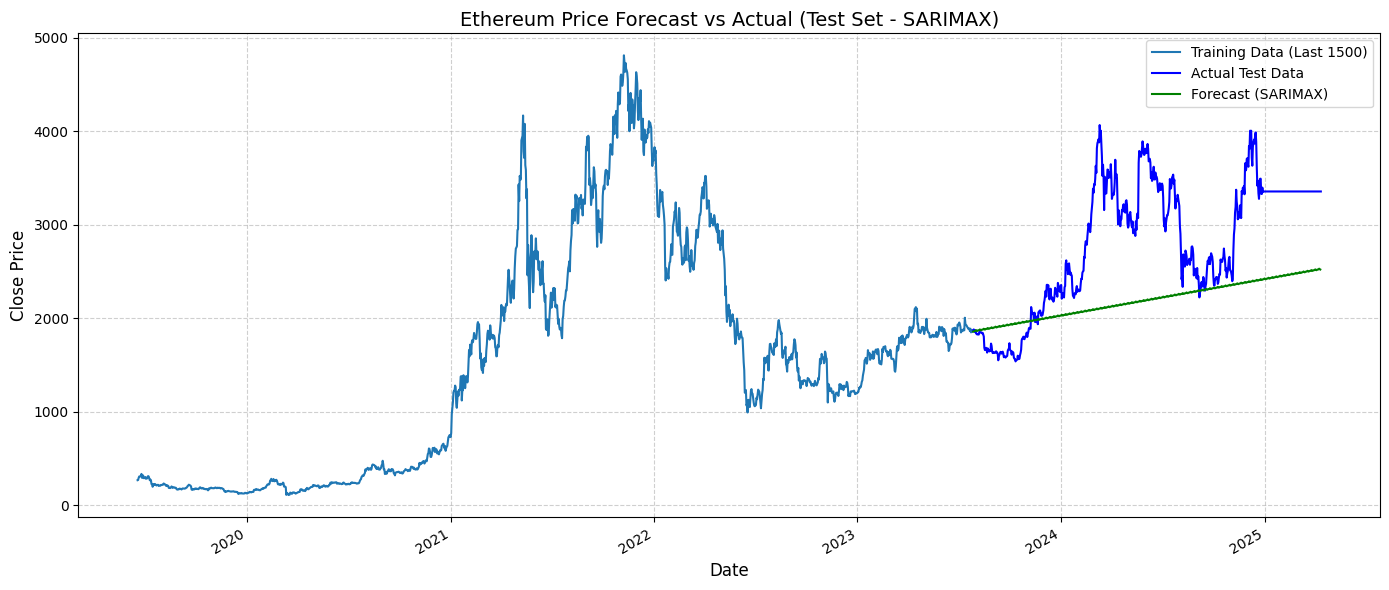

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming train_data and merged_test_data are already loaded and processed
# Make sure train_data has a proper datetime index and 'Close' column

# Select the last 1500 data points for training (as specified)
train_df_subset = train_data['Close'][-1500:]

# Define the order and seasonal order based on your auto_arima results
order = (0, 1, 1)
seasonal_order = (0, 1, 1, 7)  # Assuming this was the seasonal order found by auto_arima

# For SARIMAX, you can include exogenous variables in the 'exog' parameter
# If you don't have any exogenous variables yet, you can leave this as None
exog_train = None
exog_test = None

# Fit the SARIMAX model
model_sarimax = SARIMAX(train_df_subset, order=order, seasonal_order=seasonal_order, exog=exog_train)
results_sarimax = model_sarimax.fit(disp=False) # disp=False to suppress convergence messages

print(results_sarimax.summary())

# Forecast on the test set
start = len(train_df_subset)
end = start + len(merged_test_data) - 1
forecast = results_sarimax.predict(start=start, end=end, exog=exog_test)

# Create a pandas Series for the forecast
forecast_index = merged_test_data.index
forecast_series = pd.Series(forecast, index=forecast_index)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(merged_test_data['Close'], forecast))
print(f'RMSE for SARIMAX: {rmse}')

# Calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = calculate_mape(merged_test_data['Close'], forecast)
print(f'MAPE for SARIMAX: {mape}')

# Optional: Plotting the actual vs forecasted values
plt.figure(figsize=(14, 6))
plt.plot(train_df_subset.index, train_df_subset, label='Training Data (Last 1500)')
plt.plot(merged_test_data.index, merged_test_data['Close'], label='Actual Test Data', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Forecast (SARIMAX)', color='green')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.title('Ethereum Price Forecast vs Actual (Test Set - SARIMAX)', fontsize=14)
plt.gcf().autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
import pmdarima as pm
import pandas as pd

# Assuming train_data is loaded and has 'Close' column

train_df_subset = train_data['Close'][-1500:] # Or -1800, you can try both

# Run auto_arima for SARIMAX
model_sarimax_auto = pm.auto_arima(
    train_df_subset,
    seasonal=True,
    m=7,  # Start with 7, but try other values like 14, or even consider other periods
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    max_p=5, max_d=2, max_q=5,
    max_P=3, max_D=2, max_Q=3, # You can try increasing these as well
    information_criterion='aic', # You can also try 'bic' or 'hqic'
    trace=True # This will show you the models it's evaluating
)

print(f"Best SARIMAX model found by auto_arima: {model_sarimax_auto}")

# You can then use the order and seasonal_order from this output in your SARIMAX code
best_order = model_sarimax_auto.order
best_seasonal_order = model_sarimax_auto.seasonal_order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=17677.318, Time=2.80 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=17675.715, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=17671.849, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=17672.051, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=17673.934, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=17670.139, Time=0.07 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=17671.812, Time=0.25 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=17673.139, Time=1.02 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=17671.911, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=17672.018, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=17670.395, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=17672.707, Time=0.81 sec
 ARIMA(1,1,0)(0,0,0)[7]             : AIC=17668.392, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7]             : AIC=17670.108, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 1500
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -9107.119
Date:                           Tue, 22 Apr 2025   AIC                          18230.238
Time:                                   19:36:30   BIC                          18272.744
Sample:                               06-19-2019   HQIC                         18246.073
                                    - 07-27-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Volume     -6.701e-10    1.7e-10     -3.940      0.000      -1e-09   -3.37e-10
MA_30          1.1661   3.37e-05   3.46e+04

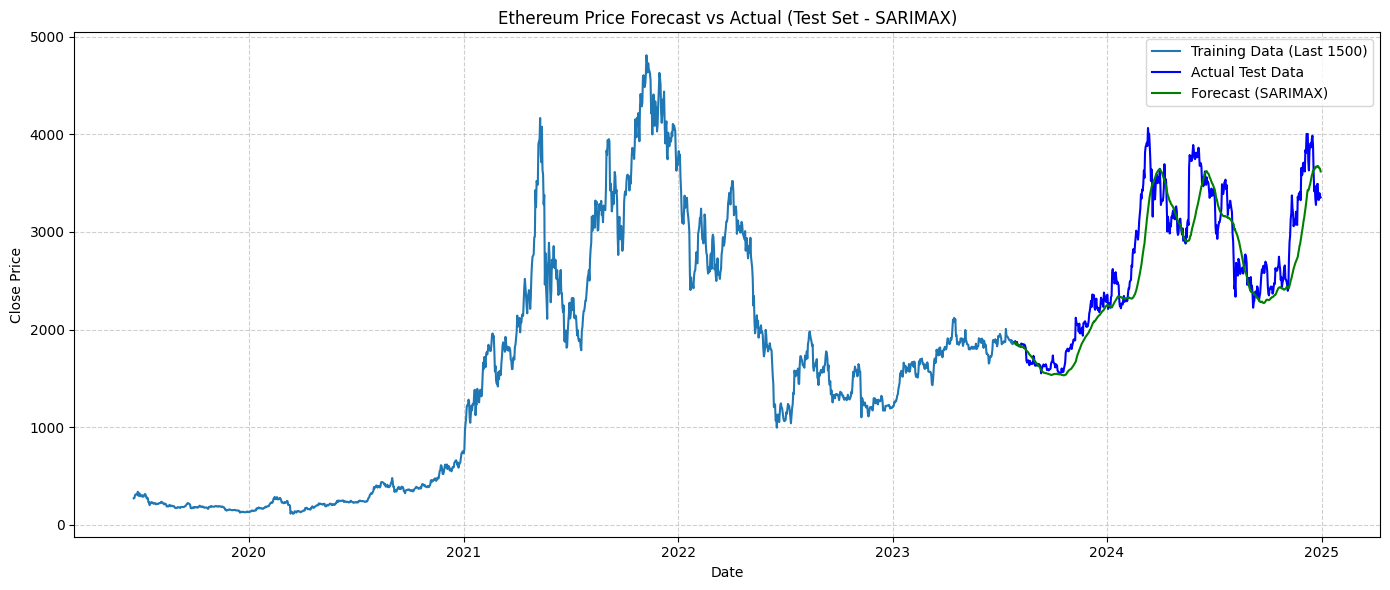

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Prepare training data
train_df_subset = train_data['Close'][-1500:]
exog_train = train_data[['Volume', 'MA_30', 'MA_90']].iloc[-1500:]

# Prepare test data
exog_test = merged_test_data[['Volume', 'MA_30', 'MA_90']]

# Drop NaNs from exog_test and sync the test data accordingly
valid_rows = ~exog_test.isna().any(axis=1)
exog_test_clean = exog_test[valid_rows]
merged_test_data_clean = merged_test_data.loc[exog_test_clean.index]

# Fit SARIMAX model
order = (1, 0, 1)
seasonal_order = (1, 0, 1, 7)
model_sarimax = SARIMAX(train_df_subset, order=order, seasonal_order=seasonal_order, exog=exog_train)
results_sarimax = model_sarimax.fit(disp=False)

print(results_sarimax.summary())

# Forecast
start = len(train_df_subset)
forecast = results_sarimax.predict(start=start, end=start + len(exog_test_clean) - 1, exog=exog_test_clean)
forecast_series = pd.Series(forecast, index=merged_test_data_clean.index)

# Evaluation
rmse = np.sqrt(mean_squared_error(merged_test_data_clean['Close'], forecast_series))
print(f'RMSE for SARIMAX: {rmse:.2f}')

def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = calculate_mape(merged_test_data_clean['Close'], forecast_series)
print(f'MAPE for SARIMAX: {mape:.2f}%')

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(train_df_subset.index, train_df_subset, label='Training Data (Last 1500)')
plt.plot(merged_test_data_clean['Close'], label='Actual Test Data', color='blue')
plt.plot(forecast_series, label='Forecast (SARIMAX)', color='green')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Ethereum Price Forecast vs Actual (Test Set - SARIMAX)')
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
print("Any NaNs in exog_test:", exog_test.isna().sum())
print("Any Infs in exog_test:", np.isinf(exog_test).sum())


Any NaNs in exog_test: Volume    102
MA_30     102
MA_90     102
dtype: int64
Any Infs in exog_test: Volume    0
MA_30     0
MA_90     0
dtype: int64


In [32]:
# Drop rows with NaNs in exog_test
valid_rows = ~exog_test.isna().any(axis=1)
exog_test_clean = exog_test[valid_rows]
merged_test_data_clean = merged_test_data.loc[exog_test_clean.index]

# Update forecast range
start = len(train_df_subset)
forecast = results_sarimax.predict(start=start, end=start + len(exog_test_clean) - 1, exog=exog_test_clean)


                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 1500
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -9107.119
Date:                           Tue, 22 Apr 2025   AIC                          18230.238
Time:                                   19:36:53   BIC                          18272.744
Sample:                               06-19-2019   HQIC                         18246.073
                                    - 07-27-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Volume     -6.701e-10    1.7e-10     -3.940      0.000      -1e-09   -3.37e-10
MA_30          1.1661   3.37e-05   3.46e+04

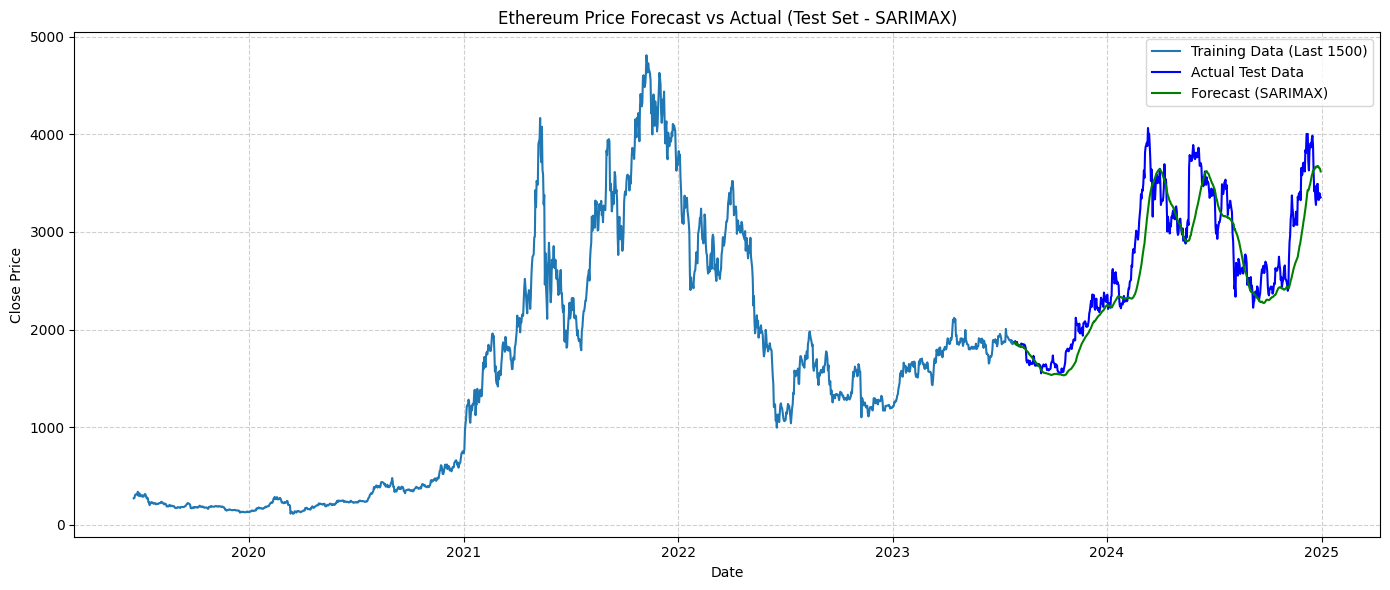

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Prepare training data
train_df_subset = train_data['Close'][-1500:]
exog_train = train_data[['Volume', 'MA_30', 'MA_90']].iloc[-1500:]

# Prepare test data
exog_test = merged_test_data[['Volume', 'MA_30', 'MA_90']]

# Drop NaNs from exog_test and sync the test data accordingly
valid_rows = ~exog_test.isna().any(axis=1)
exog_test_clean = exog_test[valid_rows]
merged_test_data_clean = merged_test_data.loc[exog_test_clean.index]

# Fit SARIMAX model
order = (1, 0, 1)
seasonal_order = (1, 0, 1, 7)
model_sarimax = SARIMAX(train_df_subset, order=order, seasonal_order=seasonal_order, exog=exog_train)
results_sarimax = model_sarimax.fit(disp=False)

print(results_sarimax.summary())

# Forecast
start = len(train_df_subset)
forecast = results_sarimax.predict(start=start, end=start + len(exog_test_clean) - 1, exog=exog_test_clean)
forecast_series = pd.Series(forecast, index=merged_test_data_clean.index)

# Evaluation
rmse = np.sqrt(mean_squared_error(merged_test_data_clean['Close'], forecast_series))
print(f'RMSE for SARIMAX: {rmse:.2f}')

def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = calculate_mape(merged_test_data_clean['Close'], forecast_series)
print(f'MAPE for SARIMAX: {mape:.2f}%')

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(train_df_subset.index, train_df_subset, label='Training Data (Last 1500)')
plt.plot(merged_test_data_clean['Close'], label='Actual Test Data', color='blue')
plt.plot(forecast_series, label='Forecast (SARIMAX)', color='green')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Ethereum Price Forecast vs Actual (Test Set - SARIMAX)')
plt.legend()
plt.tight_layout()
plt.show()


> finally a prediction, lets focus on tuning the model now ;)

In [ ]:
"""
import warnings
warnings.filterwarnings("ignore")
import itertools
from tqdm import tqdm

# Set ranges
p = q = P = Q = [0, 1, 2]
d = D = [0]
s = [7]  # Weekly seasonality

# Create parameter grid
param_grid = list(itertools.product(p, d, q))
seasonal_grid = list(itertools.product(P, D, Q, s))

best_rmse = float('inf')
best_order = None
best_seasonal_order = None

print("Tuning SARIMAX parameters...")

for order in tqdm(param_grid):
    for seasonal_order in seasonal_grid:
        try:
            model = SARIMAX(train_df_subset, order=order, seasonal_order=seasonal_order, exog=exog_train)
            result = model.fit(disp=False)
            forecast = result.predict(start=len(train_df_subset),
                                      end=len(train_df_subset) + len(exog_test_clean) - 1,
                                      exog=exog_test_clean)
            rmse = np.sqrt(mean_squared_error(merged_test_data_clean['Close'], forecast))

            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_seasonal_order = seasonal_order
        except Exception as e:
            continue

print(f"\nBest RMSE: {best_rmse:.2f}")
print(f"Best order: {best_order}")
print(f"Best seasonal_order: {best_seasonal_order}")
"""


Tuning SARIMAX parameters...


  0%|          | 0/9 [00:00<?, ?it/s]c:\Users\Ash\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\Ash\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\Ash\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Ash\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\Ash\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provid


Best RMSE: 260.92
Best order: (0, 0, 0)
Best seasonal_order: (2, 0, 2, 7)


                                  SARIMAX Results                                   
Dep. Variable:                        Close   No. Observations:                 1200
Model:             SARIMAX(2, 0, [1, 2], 7)   Log Likelihood               -8160.538
Date:                      Tue, 22 Apr 2025   AIC                          16337.075
Time:                              19:37:23   BIC                          16377.796
Sample:                          04-14-2020   HQIC                         16352.414
                               - 07-27-2023                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Volume      4.432e-09   5.47e-10      8.105      0.000    3.36e-09     5.5e-09
MA_30          1.1568      0.004    279.867      0.000       1.149       1.165
MA_9

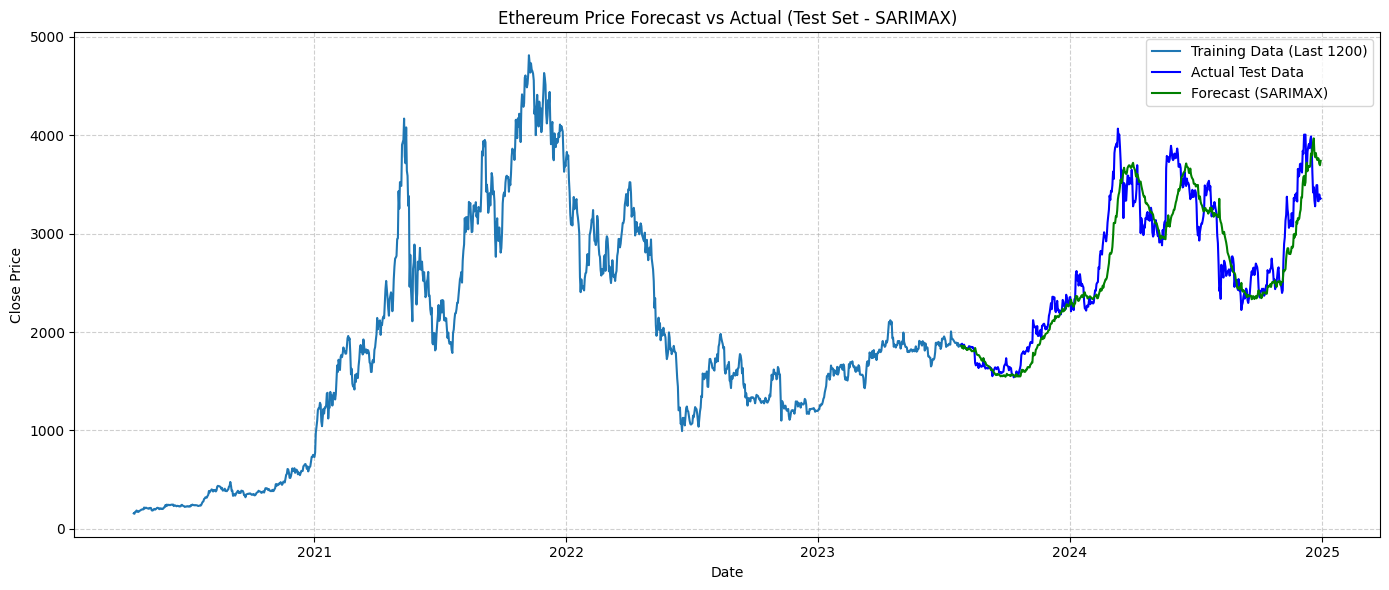

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Prepare training data
train_df_subset = train_data['Close'][-1200:]
exog_train = train_data[['Volume', 'MA_30', 'MA_90']].iloc[-1200:]

# Prepare test data
exog_test = merged_test_data[['Volume', 'MA_30', 'MA_90']]

# Drop NaNs from exog_test and sync the test data accordingly
valid_rows = ~exog_test.isna().any(axis=1)
exog_test_clean = exog_test[valid_rows]
merged_test_data_clean = merged_test_data.loc[exog_test_clean.index]

# Fit SARIMAX model
order = (0,0,0)
seasonal_order = (2, 0, 2, 7)
model_sarimax = SARIMAX(train_df_subset, order=order, seasonal_order=seasonal_order, exog=exog_train)
results_sarimax = model_sarimax.fit(disp=False)

print(results_sarimax.summary())

# Forecast
start = len(train_df_subset)
forecast = results_sarimax.predict(start=start, end=start + len(exog_test_clean) - 1, exog=exog_test_clean)
forecast_series = pd.Series(forecast, index=merged_test_data_clean.index)

# Evaluation
rmse = np.sqrt(mean_squared_error(merged_test_data_clean['Close'], forecast_series))
print(f'RMSE for SARIMAX: {rmse:.2f}')

def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = calculate_mape(merged_test_data_clean['Close'], forecast_series)
print(f'MAPE for SARIMAX: {mape:.2f}%')

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(train_df_subset.index, train_df_subset, label='Training Data (Last 1200)')
plt.plot(merged_test_data_clean['Close'], label='Actual Test Data', color='blue')
plt.plot(forecast_series, label='Forecast (SARIMAX)', color='green')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Ethereum Price Forecast vs Actual (Test Set - SARIMAX)')
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
from sklearn.model_selection import TimeSeriesSplit

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=4)  # You can use 3 or any other value instead of 5
rmse_scores = []
mape_scores = []

print(f"\nCross-validating SARIMAX{order}{seasonal_order}...")

for fold, (train_idx, test_idx) in enumerate(tscv.split(train_df_subset)):
    train_y = train_df_subset.iloc[train_idx]
    test_y = train_df_subset.iloc[test_idx]
    
    train_exog = exog_train.iloc[train_idx]
    test_exog = exog_train.iloc[test_idx]
    
    model = SARIMAX(train_y, order=order, seasonal_order=seasonal_order, exog=train_exog)
    result = model.fit(disp=False)
    
    forecast = result.forecast(steps=len(test_y), exog=test_exog)
    
    rmse = np.sqrt(mean_squared_error(test_y, forecast))
    mape = calculate_mape(test_y, forecast)
    
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    
    print(f"Fold {fold+1}: RMSE = {rmse:.2f}, MAPE = {mape:.2f}%")

print(f"\nAverage RMSE: {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")
print(f"Average MAPE: {np.mean(mape_scores):.2f}% ± {np.std(mape_scores):.2f}%")



Cross-validating SARIMAX(0, 0, 0)(2, 0, 2, 7)...
Fold 1: RMSE = 386.61, MAPE = 13.74%
Fold 2: RMSE = 456.69, MAPE = 10.72%
Fold 3: RMSE = 283.47, MAPE = 14.36%
Fold 4: RMSE = 118.44, MAPE = 5.62%

Average RMSE: 311.30 ± 127.26
Average MAPE: 11.11% ± 3.46%


In [35]:
import joblib

# Save the model to a file
joblib.dump(results_sarimax, 'sarimax_model.pkl')


['sarimax_model.pkl']